In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

Para el trabajo se eligió un dataset con datos de dos años del consumo eléctrico por hora de un departamento en San Jose, California. Como el dataset tenía tantas entradas se decidió tomar el valor de consumo máximo diario. Esto redujo el dataset de 70.000 entradas a 733 entradas.

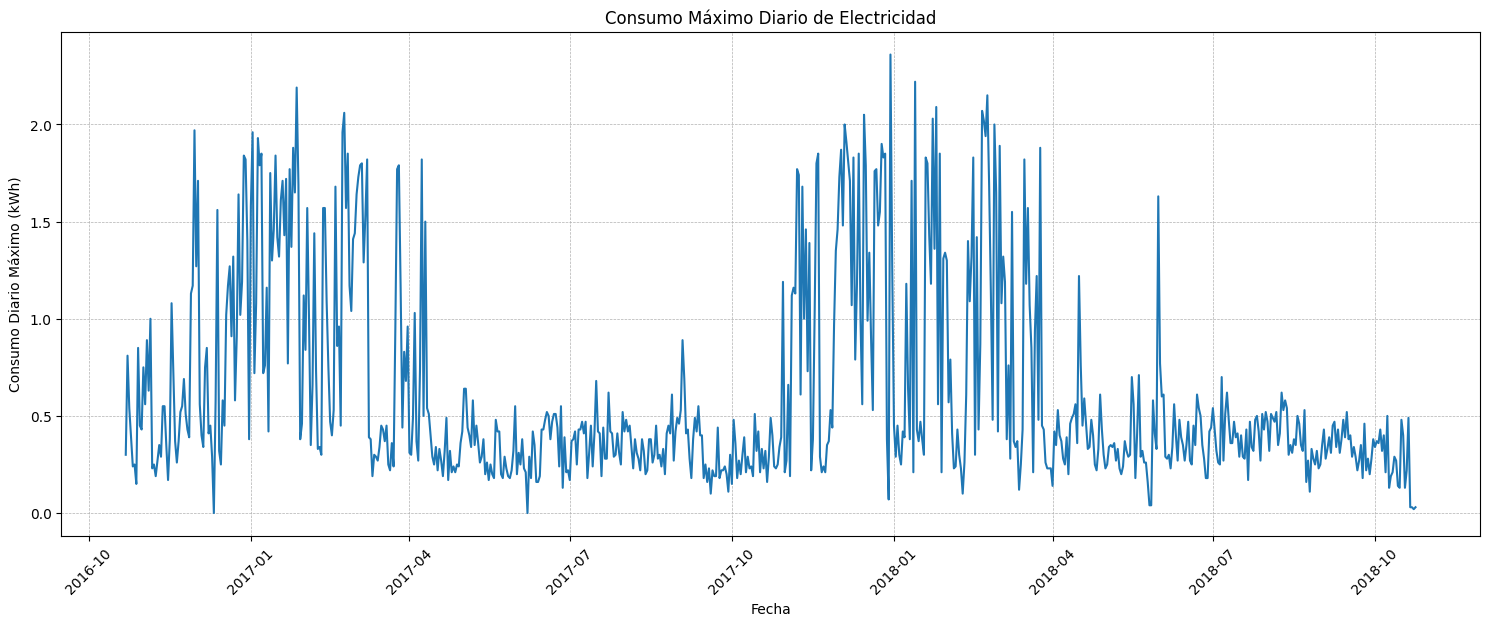

In [19]:
df = pd.read_csv("Datasets/tp_final/df_max_usage.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index(df["DATE"])

df.replace(0, 1e-100, inplace=True)

plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['MAX_USAGE'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Consumo Diario Máximo (kWh)')
plt.title('Consumo Máximo Diario de Electricidad')
plt.tight_layout()

if len(df) > 50:
    plt.xticks(rotation=45)

plt.show()

Como se puede observar, es una serie discreta y univariada. Claramente presenta estacionalidad: en los meses más fríos en California, de octubre a abril, el consumo de electricidad aumenta considerablemente. De la misma manera, en los meses más cálidos disminuye considerablemente. En primer lugar no pareciera ser estacionaria, porque, a simple vista, la media y la varianza de los valores cambia a lo largo del tiempo.
La serie se descompone utilizando el **modelo multiplicativo**, utilizando un **período de 365 días** (o entradas). Este período ha sido seleccionado para capturar la ventana de tiempo en la cual se observa la estacionalidad.


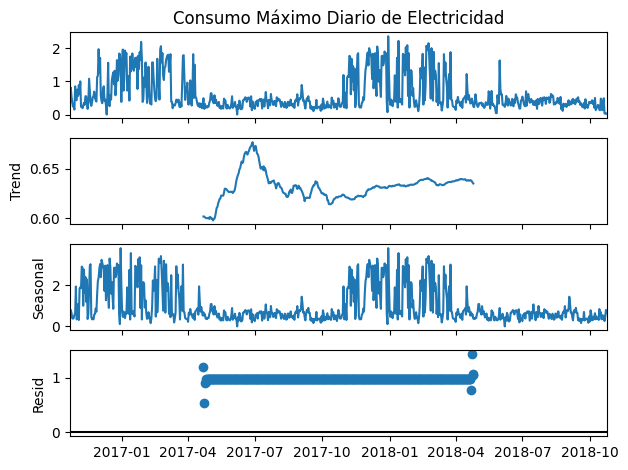

In [20]:
series = pd.Series(
    df['MAX_USAGE'].values, index=df['DATE'], name="Consumo Máximo Diario de Electricidad"
)

period = 365
decomposition = seasonal_decompose(series, model='multiplicative', period=period)
decomposition.plot()
plt.show()

Como se puede observar este modelo no parece ser efectivo para el estudio de la serie: la componente estacional termina sirviendo para represnetar casi toda la serie original. La tendencia y los residuos son marginales. Este mismo problema sucede si se usa un modelo aditivo.

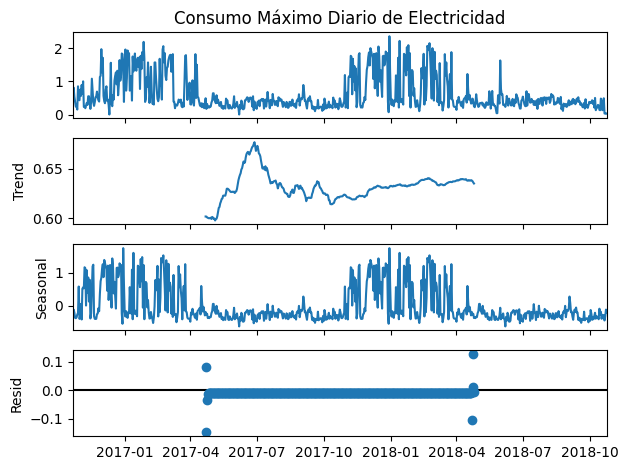

In [21]:
period = 365
decomposition = seasonal_decompose(series, model='additive', period=period)
decomposition.plot()
plt.show()

Se decide entonces estimar una tendencia de forma manual, para despues restarle los efectos de esta tendencia a la serie original.
Como se puede estimar a simple vista el periodo es de 360 dias.

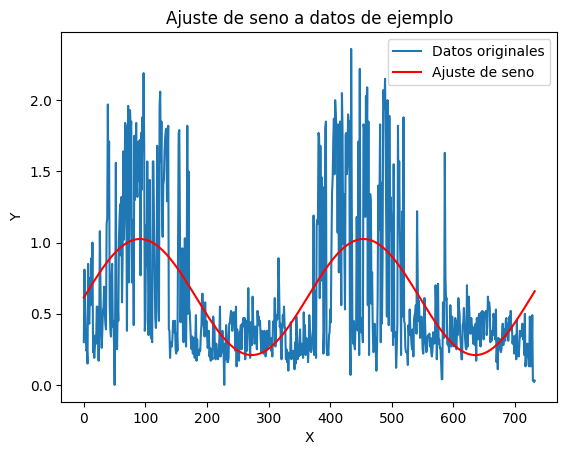

Parámetros ajustados:
Amplitud (A): -0.8151705077182209
Frecuencia (omega): 0.008658038926308103
Fase (phi): 2.3519707148840947
Desplazamiento (offset): 1.0248747731056256


In [22]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

x_list = np.array(list(range(len(series.index))))
y_list = series.values

def sine_func(x, A, omega, phi, offset):
    return A * np.sin(omega * x + phi) ** 2 + offset

A_guess = 2
omega_guess = 1/365
phi_guess = 0
offset_guess = 0

params, covariance = curve_fit(sine_func, x_list, y_list, p0=[A_guess, omega_guess, phi_guess, offset_guess], maxfev=10*5000)

A_fit, omega_fit, phi_fit, offset_fit = params

y_fit = sine_func(x_list, A_fit, omega_fit, phi_fit, offset_fit)


plt.plot(x_list, y_list, label='Datos originales')
plt.plot(x_list, y_fit, color='red', label='Ajuste de seno')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ajuste de seno a datos de ejemplo')
plt.show()

print('Parámetros ajustados:')
print('Amplitud (A):', A_fit)
print('Frecuencia (omega):', omega_fit)
print('Fase (phi):', phi_fit)
print('Desplazamiento (offset):', offset_fit)


Ahora se divide la serie original por el estimado, de forma de remover esta tendencia estimada de la serie.


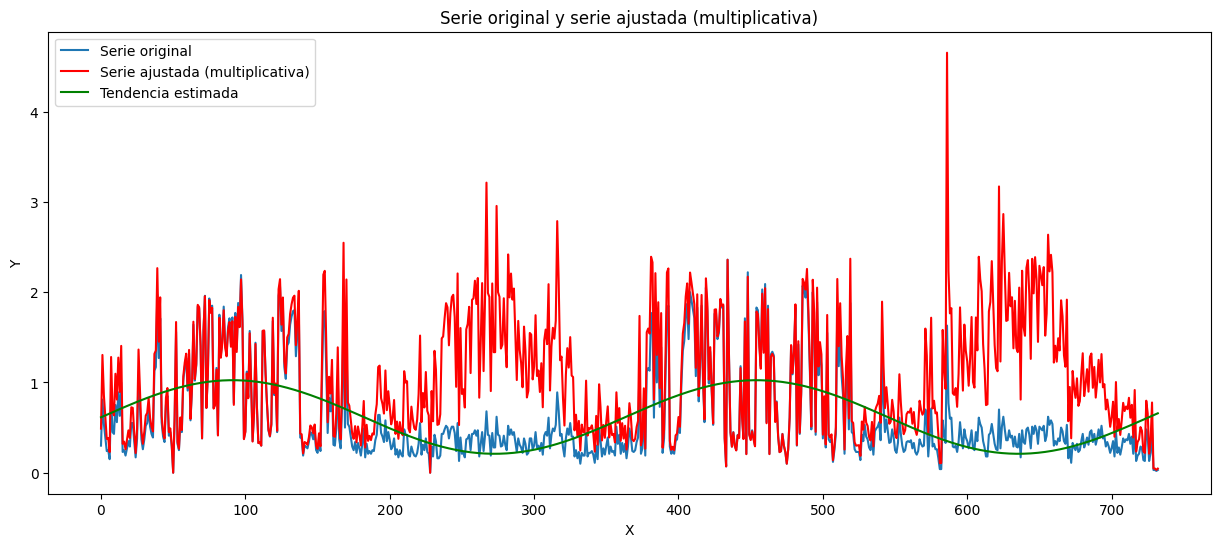

In [38]:
serie_ajustada_multiplicativa = y_list / y_fit

plt.figure(figsize=(15, 6))
plt.plot(x_list, y_list, label='Serie original')
plt.plot(x_list, serie_ajustada_multiplicativa, color='red', label='Serie ajustada (multiplicativa)')
plt.plot(x_list, y_fit, color='green', label='Tendencia estimada')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie original y serie ajustada (multiplicativa)')
plt.show()

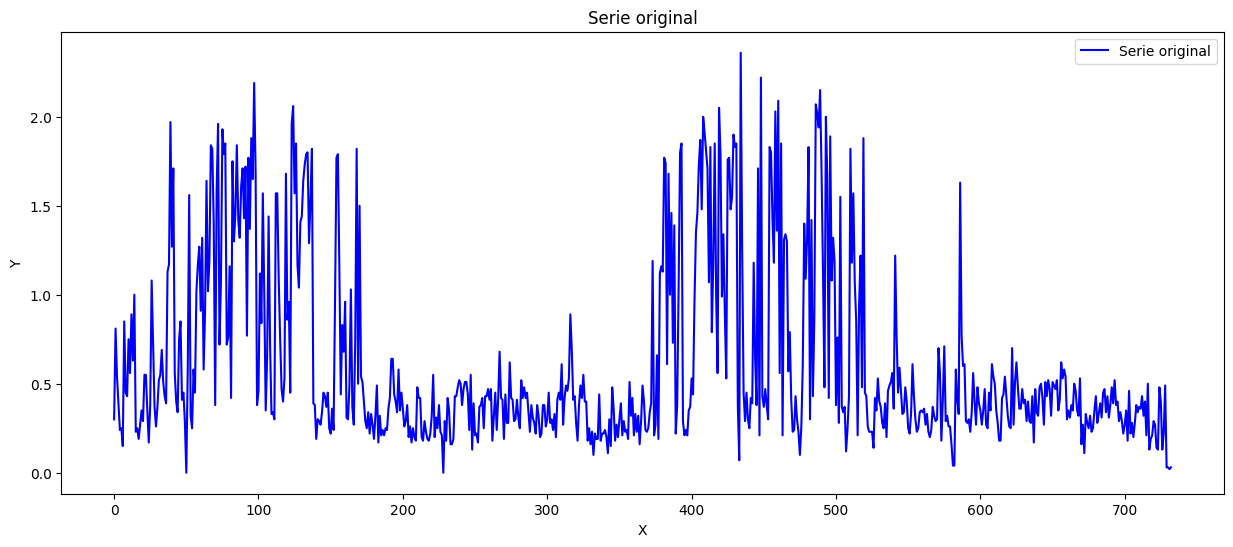

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(x_list, y_list, color='blue', label='Serie original')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie original')
plt.show()

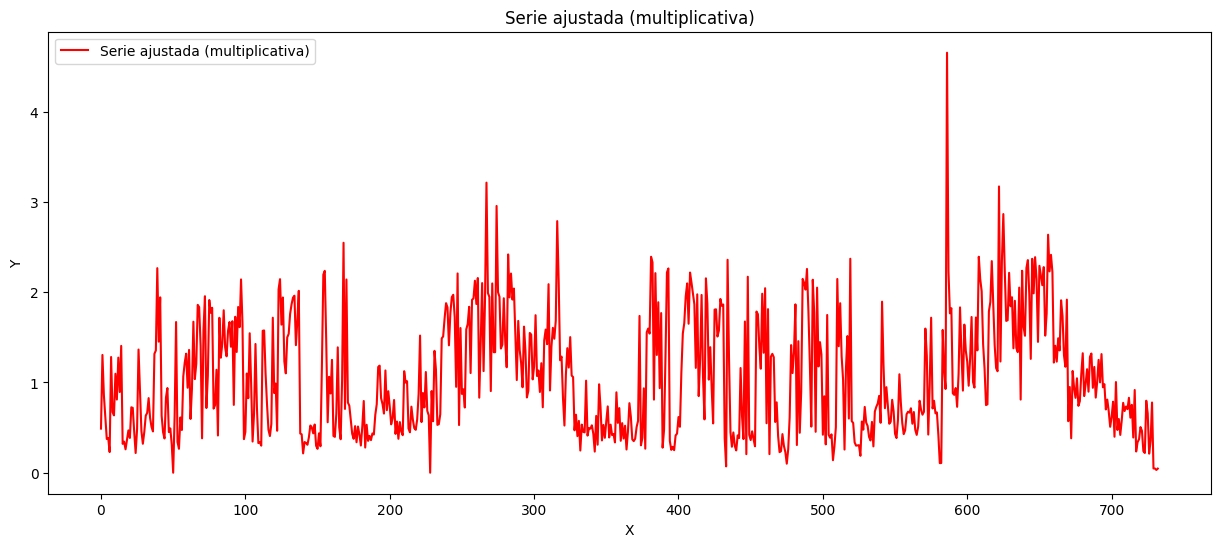

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(x_list, serie_ajustada_multiplicativa, color='red', label='Serie ajustada (multiplicativa)')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada (multiplicativa)')
plt.show()

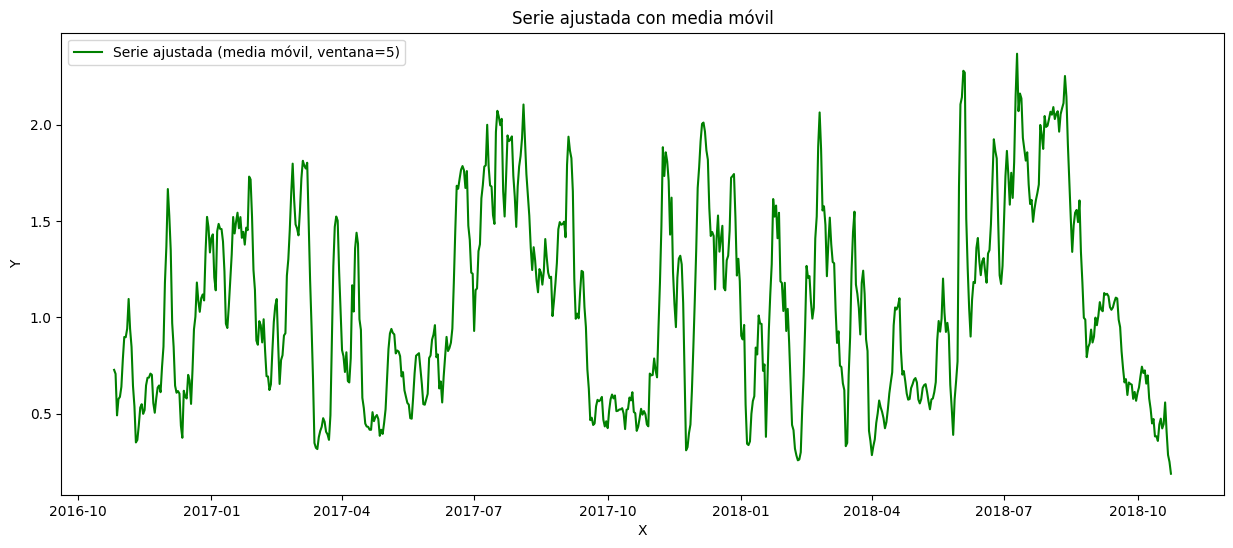

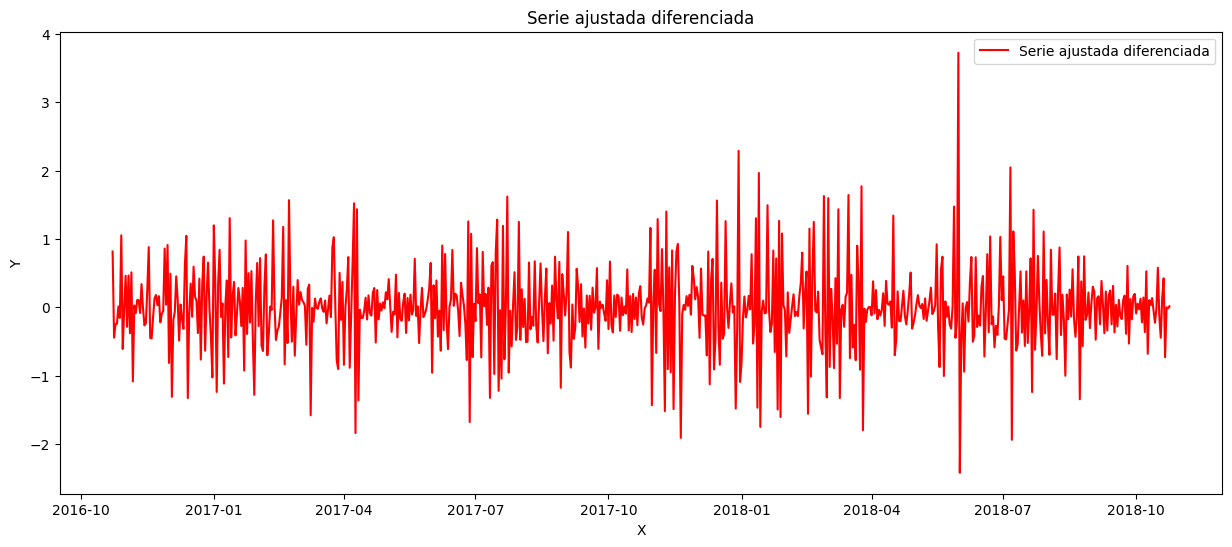

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df_ajustado = pd.DataFrame({'Serie_Ajustada': serie_ajustada_multiplicativa}, index=series.index)

window_size = 5
df_ajustado_rolling = df_ajustado.rolling(window=window_size).mean()

df_ajustado_diff = df_ajustado.diff()

plt.figure(figsize=(15, 6))
plt.plot(df_ajustado_rolling.index, df_ajustado_rolling['Serie_Ajustada'], color='green', label=f'Serie ajustada (media móvil, ventana={window_size})')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada con media móvil')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(df_ajustado_diff.index, df_ajustado_diff['Serie_Ajustada'], color='red', label='Serie ajustada diferenciada')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada diferenciada')
plt.show()

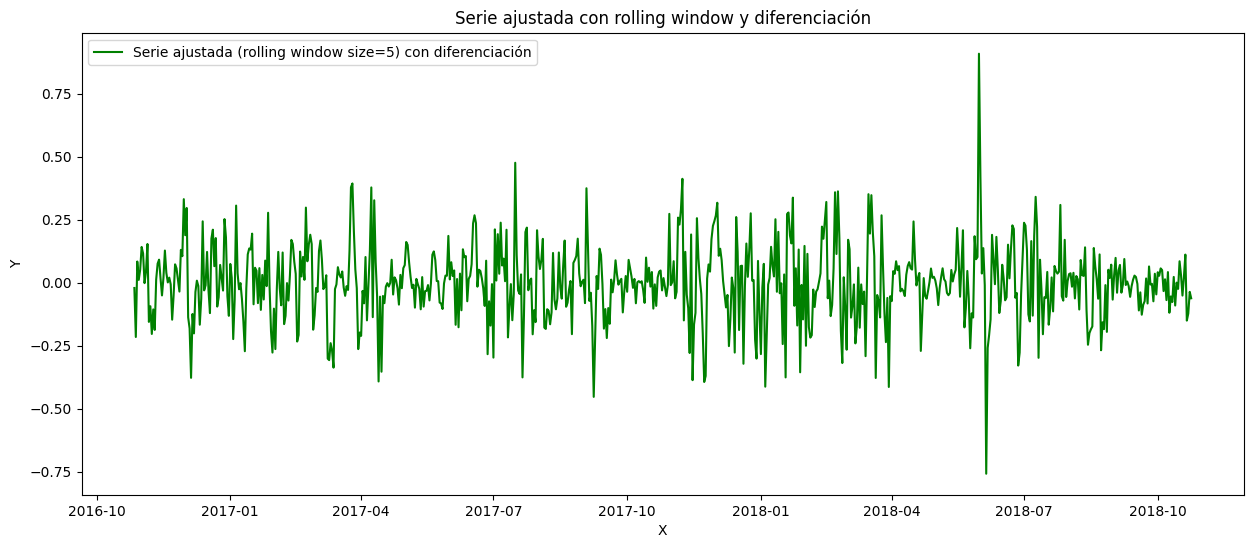

In [27]:
import pandas as pd

df_ajustado = pd.DataFrame({'Serie_Ajustada': serie_ajustada_multiplicativa}, index=series.index)

window_size = 5
df_ajustado_rolling = df_ajustado.rolling(window=window_size).mean()

df_ajustado_rolling_diff = df_ajustado_rolling.diff()

plt.figure(figsize=(15, 6))
plt.plot(df_ajustado_rolling_diff.index, df_ajustado_rolling_diff['Serie_Ajustada'], color='green', label=f'Serie ajustada (rolling window size={window_size}) con diferenciación')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Serie ajustada con rolling window y diferenciación')
plt.show()

## hacer test de estacionaridad -> la mas sencilla que sea estacionaria

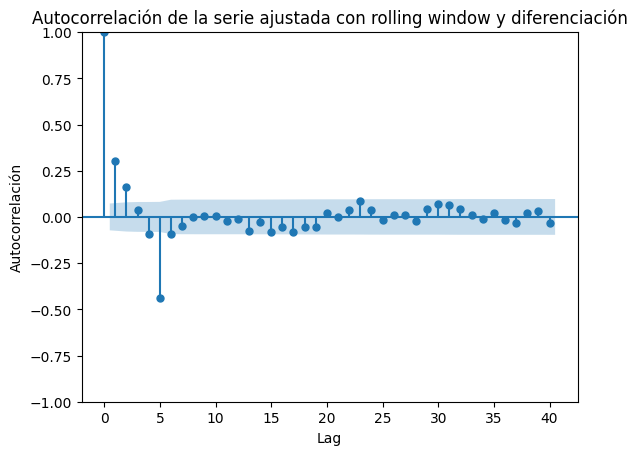

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_ajustado_rolling_diff['Serie_Ajustada'].dropna(), lags=40) ## -> ver parte de MA
## autocorrleacion parcial -> 
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la serie ajustada con rolling window y diferenciación')
plt.show()

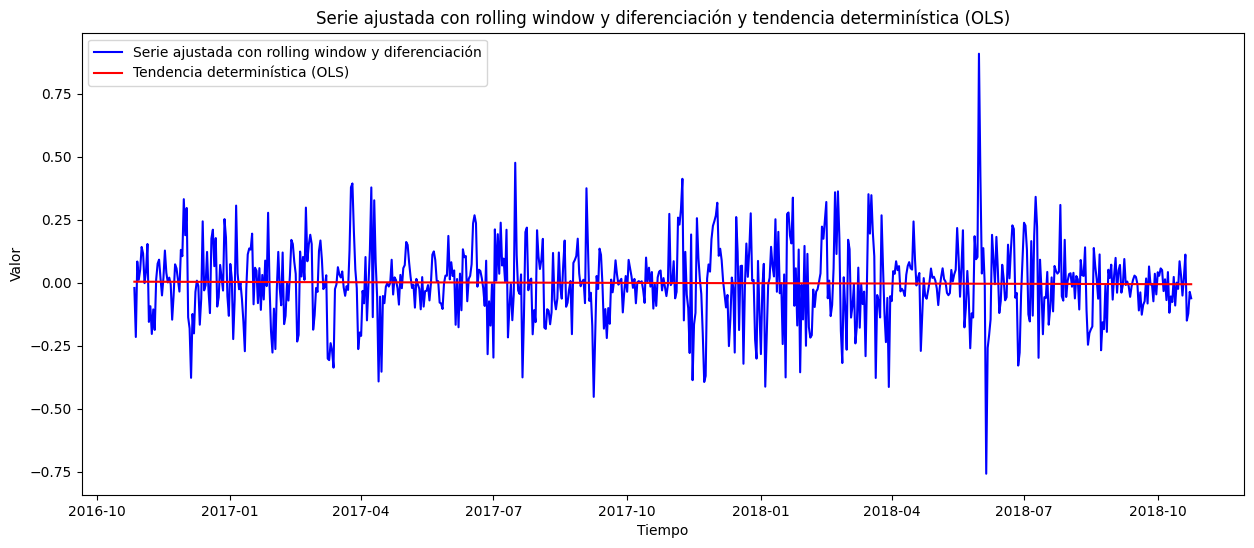

In [29]:
import statsmodels.api as sm

y = df_ajustado_rolling_diff['Serie_Ajustada'].dropna()

y_dates = y.index

x_with_const = sm.add_constant(np.arange(len(y)))

model_ols = sm.OLS(y, x_with_const).fit()

trend_ols = model_ols.predict(x_with_const)

plt.figure(figsize=(15, 6))
plt.plot(y_dates, y, color='blue', label='Serie ajustada con rolling window y diferenciación')
plt.plot(y_dates, trend_ols, color='red', label='Tendencia determinística (OLS)')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie ajustada con rolling window y diferenciación y tendencia determinística (OLS)')
plt.show()

Considerando el grafico de autocorrelacion y la tendencia deterministica se podria considerar que la serie ajustada podria ser estacionaria, aunque no es suficiente para garantizarlo.

A partir de estos resultados se podria plantear un modelo SARIMA considerando lo siguiente: una diferenciacion de primer orden para el componente I, una ventana de 5 dias para el componente MA y utilizar un lag de 5 para el componente AR, dado que es el pico dentro del intervalo de confianza.  

/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(0, 1, 0)   Log Likelihood                -448.377
Date:                                   Sat, 06 Apr 2024   AIC                            898.754
Time:                                           10:25:58   BIC                            903.350
Sample:                                       10-22-2016   HQIC                           900.527
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1993      0.006     33.989      0.000    

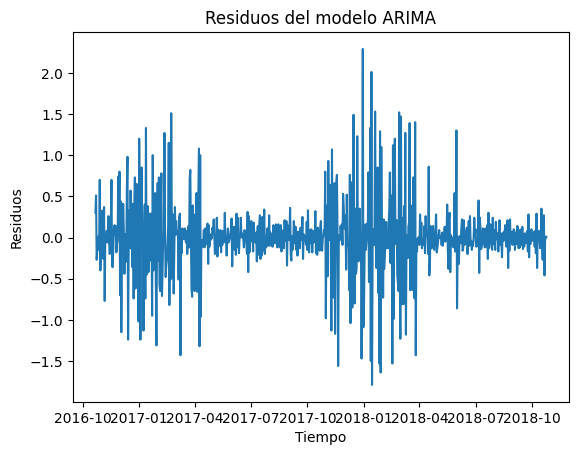

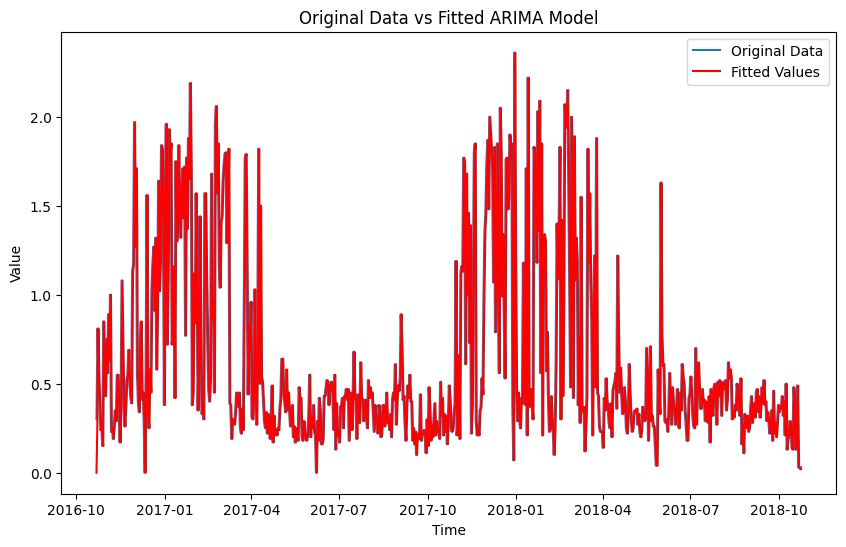

In [35]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(series, order=(0, 1, 0))
modelo_arima_resultados = modelo_arima.fit()

print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

import matplotlib.pyplot as plt

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(series.index, series.values, label='Original Data')

# Plot the fitted values of the ARIMA model
plt.plot(series.index, modelo_arima_resultados.fittedvalues, color='red', label='Fitted Values')

plt.title('Original Data vs Fitted ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(1, 1, 1)   Log Likelihood                -332.298
Date:                                   Sat, 06 Apr 2024   AIC                            670.597
Time:                                           10:26:24   BIC                            684.384
Sample:                                       10-22-2016   HQIC                           675.915
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2473      0.032      7.793      0.000    

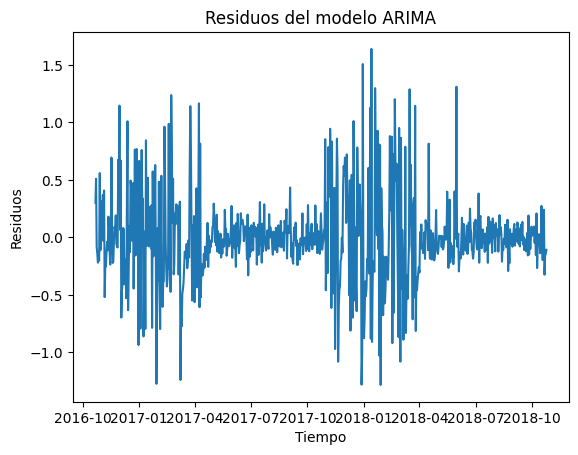

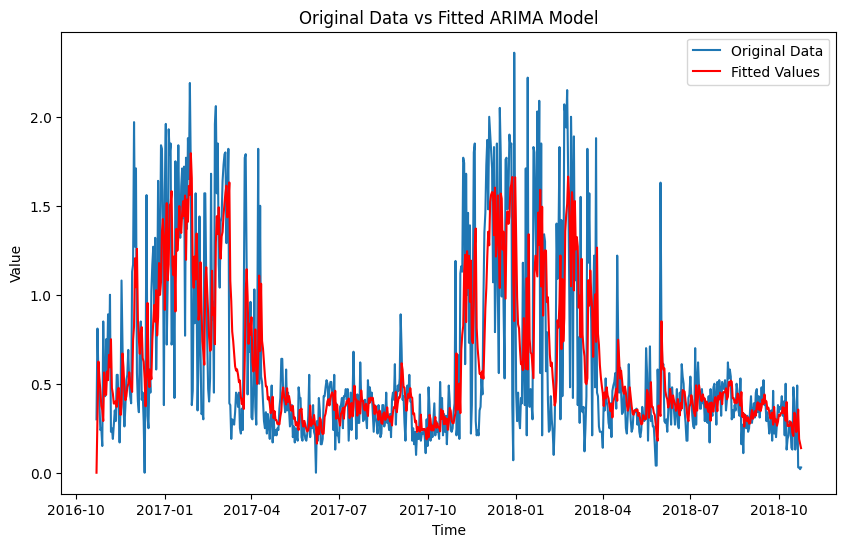

In [36]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(series, order=(1, 1, 1))
modelo_arima_resultados = modelo_arima.fit()

print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

import matplotlib.pyplot as plt

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(series.index, series.values, label='Original Data')

# Plot the fitted values of the ARIMA model
plt.plot(series.index, modelo_arima_resultados.fittedvalues, color='red', label='Fitted Values')

plt.title('Original Data vs Fitted ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rodrigo.pazos/projects/sts/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rodrigo.pazos/projects/sts/venv

                                         SARIMAX Results                                         
Dep. Variable:     Consumo Máximo Diario de Electricidad   No. Observations:                  733
Model:                                    ARIMA(5, 1, 5)   Log Likelihood                -323.416
Date:                                   Sat, 06 Apr 2024   AIC                            668.832
Time:                                           10:26:35   BIC                            719.385
Sample:                                       10-22-2016   HQIC                           688.333
                                            - 10-24-2018                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6235      0.315     -1.982      0.047    

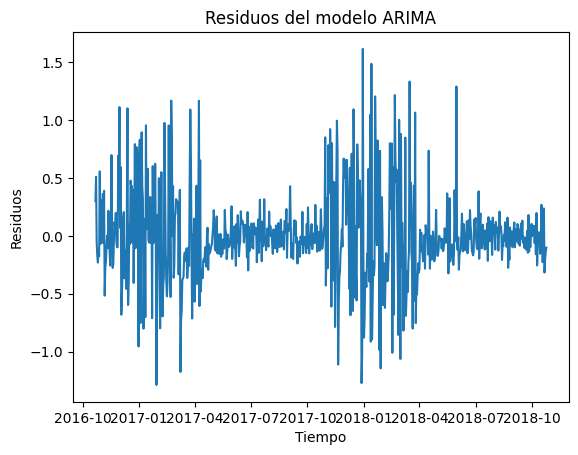

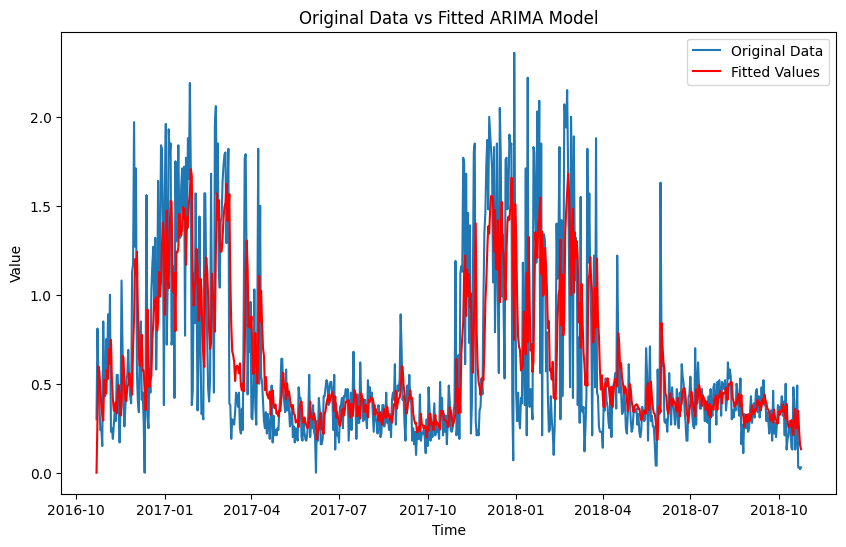

In [37]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(series, order=(5, 1, 5))
modelo_arima_resultados = modelo_arima.fit()

print(modelo_arima_resultados.summary())

residuos = modelo_arima_resultados.resid
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

import matplotlib.pyplot as plt

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(series.index, series.values, label='Original Data')

# Plot the fitted values of the ARIMA model
plt.plot(series.index, modelo_arima_resultados.fittedvalues, color='red', label='Fitted Values')

plt.title('Original Data vs Fitted ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()